In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
from netCDF4 import Dataset
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap 
import pandas as pd
from os import walk
import time
import collections
from collections import Counter
import re
import random
from random import randint
from sklearn.metrics import accuracy_score
import os
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

try:
    import cPickle as pickle
except ImportError: 
    import pickle


import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

from tensorflow.python.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [4]:
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [5]:
hudrat = pd.read_csv('ibtracs.since1980.list.v04r00.csv', delimiter = ",", skiprows = [1])
hudrat['ISO_TIME'] = pd.to_datetime(hudrat['ISO_TIME'])

In [6]:
hudrat.head(5)

SID  SEASON  NUMBER BASIN SUBBASIN  NAME            ISO_TIME  \
0  1980001S13173    1980       1    SP       MM  PENI 1980-01-01 00:00:00   
1  1980001S13173    1980       1    SP       MM  PENI 1980-01-01 03:00:00   
2  1980001S13173    1980       1    SP       MM  PENI 1980-01-01 06:00:00   
3  1980001S13173    1980       1    SP       MM  PENI 1980-01-01 09:00:00   
4  1980001S13173    1980       1    SP       MM  PENI 1980-01-01 12:00:00   

  NATURE      LAT      LON    ...    MLC_PRES USA_GUST BOM_GUST BOM_GUST_PER  \
0     TS -12.5000  172.500    ...                                              
1     TS -12.1927  172.441    ...                                              
2     TS -11.9144  172.412    ...                                              
3     TS -11.6863  172.435    ...                                              
4     TS -11.5000  172.500    ...                                              

   REUNION_GUST REUNION_GUST_PER USA_SEAHGT USA_SEARAD STORM_SPEED STORM_DIR  
0                                                                6       351  
1                                                                6       351  
2                                                                5       358  
3                                                                4        12  
4                                                                4        22  

[5 rows x 160 columns]

In [7]:
cyclones = {}
for i in range(hudrat.shape[0]):
    if hudrat['SID'][i] in cyclones:
        cyclones[hudrat['SID'][i]].append([hudrat['ISO_TIME'][i], hudrat['LAT'][i], hudrat['LON'][i]])
    else:
        cyclones[hudrat['SID'][i]] = []  

In [9]:
cyclones = dict( [(k,v) for k,v in cyclones.items() if len(v)>0])

In [10]:
len(cyclones)

4237

## saving 

In [11]:
with open('data.p', 'wb') as fp:
    pickle.dump(cyclones , fp, protocol=pickle.HIGHEST_PROTOCOL)

## loading 

In [12]:
with open('data.p', 'rb') as fp:
    cyclones = pickle.load(fp)

In [13]:
ds = Dataset('/storage/tartar/DATA/ERA5/slp/era5_mslp_1979-10.nc', 'r')
lats = np.copy(ds.variables['latitude'])
lons = np.copy(ds.variables['longitude'])
time = np.copy(ds.variables['time'])
dt0 = datetime(1900,1,1)
time_ = [dt0 + timedelta(hours=int(t)) for t in time]

In [14]:
slp = np.copy(ds.variables['msl'][743])

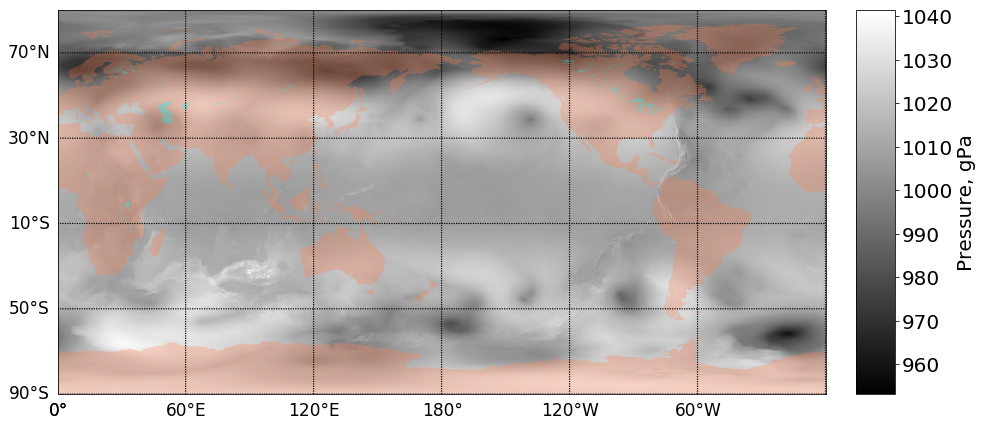

In [15]:
plt.figure(figsize = (15,15))

bm = Basemap(projection='cyl', boundinglat=-180, lon_0=180, resolution='h')

im = bm.imshow(slp, cmap = 'gray')

bm.drawparallels(np.arange(-90,90,40),linewidth=1.2, labels=[1,0,0,1], fontsize=17, color = 'black')
bm.drawmeridians(np.arange(0,360,60),linewidth=1.2, labels=[1,0,0,1], fontsize=17, color = 'black')

bm.fillcontinents(color='coral',lake_color='aqua', alpha = 0.3)

cb = bm.colorbar(im, pad='4%', size='5%')
cb.set_label(label='Pressure, gPa', size = 20)
cb.ax.set_yticklabels(['960', '970','980','990','1000','1010','1020','1030','1040'])
cb.ax.tick_params(labelsize=20)


plt.show()

In [17]:
ds.close()

In [19]:
l = datetime(1970, 1, 31, 23, 0)
k = datetime(2017, 1, 31, 23, 0)

In [20]:
cyclones_20_years= []
for i in cyclones.keys():
    if cyclones[i][0][0]>= l:
        if cyclones[i][-1][0] <= k:
            cyclones_20_years.append(i)

In [21]:
len(cyclones_20_years)

3997

In [22]:
bm = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

In [23]:
lons_mesh,lats_mesh = np.meshgrid(lons,lats)
lats_mesh.shape

(721, 1440)

In [ ]:
iterator = 0
for name in cyclones_20_years[:]:
    dict_for_arrays = {}
    
    num_of_tracks = len(cyclones[name])
    
    iterator+=1
    for i in range(num_of_tracks):
        datetime_to_find = cyclones[name][i][0]
        year = datetime_to_find.year
        month = datetime_to_find.month
        if len(str(month)) == 2:
            month = month
        else:
            month = '0' + str(month)
        dataset_name = "/storage/tartar/DATA/ERA5/slp/era5_mslp_" + str(year)+ '-' + str(month) + '.nc'
        mlp_ds = Dataset(dataset_name, 'r')
    
        dt_ancor = datetime(1900,1,1)
        ds_datetimes = np.asarray([dt_ancor + timedelta(hours=int(dt)) for dt in mlp_ds['time'][:].data])
        try:
            idx = np.where(ds_datetimes == datetime_to_find)[0][0]
            mslp_current = np.copy(mlp_ds['msl'][idx])
            
            #close dataset
            mlp_ds.close()
    
            rho = np.sqrt((lats_mesh-cyclones[name][i][1])**2 + (lons_mesh-cyclones[name][i][2])**2)
            center_pt = np.unravel_index(np.argmin(rho), rho.shape)
            cut = mslp_current[center_pt[0]-40:center_pt[0]+40, center_pt[1]-40:center_pt[1]+40]
            
            if all(i > 0 for i in center_pt):
                
                key = name
                dict_for_arrays.setdefault(key, [])
                dict_for_arrays[key].append([np.asarray(cut),ds_datetimes[i]])
    
               
        except:
            mlp_ds.close()
            pass
    
                
    pi_name = "./Cuts/" + name
                
    if len(dict_for_arrays) != 0:
        with open(pi_name, 'wb') as fp:
            pickle.dump(dict_for_arrays[name] , fp, protocol=pickle.HIGHEST_PROTOCOL)

## loading  from Cuts

In [24]:
names = []
for (dirpath, dirnames, filenames) in walk("./Cuts/"):      
    names.extend(filenames)
    break

In [25]:
len(names)

2624

## Creating helping dataset datetime-name-index

In [26]:
df = pd.DataFrame(columns=['datetime', 'name', 'index'])

In [27]:
for name in tqdm(names[:]):
    for i in range(len(cyclones[name])):
        lat = cyclones[name][i][1]
        long = cyclones[name][i][2]
        df = df.append({'datetime' : datetime.strptime(cyclones[name][i][0].strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'),
               'name':name ,'index' : i, 'long' : long, 'lat' : lat } , ignore_index=True)

100%|██████████| 2624/2624 [17:03<00:00,  2.30it/s]


In [28]:
df = df.sort_values(by='datetime')

In [29]:
df.head(10)

datetime           name index      lat      long
45016  1980-01-01 03:00:00  1980001S13173     0 -12.1927  172.4410
45017  1980-01-01 06:00:00  1980001S13173     1 -11.9144  172.4120
45018  1980-01-01 09:00:00  1980001S13173     2 -11.6863  172.4350
45019  1980-01-01 12:00:00  1980001S13173     3 -11.5000  172.5000
45020  1980-01-01 15:00:00  1980001S13173     4 -11.3225  172.5860
149810 1980-01-01 15:00:00  1980002S15081     0 -15.0075   80.3426
45021  1980-01-01 18:00:00  1980001S13173     5 -11.2038  172.7030
149811 1980-01-01 18:00:00  1980002S15081     1 -14.8000   80.2000
149812 1980-01-01 21:00:00  1980002S15081     2 -14.3774   80.1300
45022  1980-01-01 21:00:00  1980001S13173     6 -11.1525  172.8510

In [30]:
with open('dt_name_ind.p', 'wb') as fp:
    pickle.dump(df , fp, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('dt_name_ind.p', 'rb') as fp:
    df = pickle.load(fp)

In [32]:
test_names = np.unique(df[df['datetime'] >= '2010-01-01']['name'])

In [33]:
train_names = np.unique(df[df['datetime'] < '2010-01-01']['name'])

In [34]:
print("Train set:", len(train_names))
print("Test set:", len(test_names))

Train set: 2203
Test set: 421


In [35]:
for name in tqdm(test_names[:1]):
    pi_name = "./Cuts/" + name
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)

100%|██████████| 1/1 [00:00<00:00, 120.14it/s]


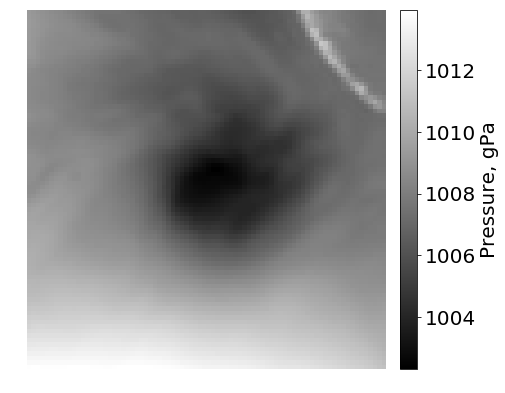

In [36]:
plt.figure(figsize = (7,7))
ax = plt.gca()
im = plt.imshow(cyclone_track[2][0], cmap='gray')
plt.axis('off')

bm = Basemap(projection='cyl', boundinglat=-180, lon_0=180, resolution='h')
cb = bm.colorbar(im, pad='4%', size='5%')
cb.set_label(label='Pressure, gPa', size = 20)
cb.ax.set_yticklabels(['1004','1006', '1008', '1010', '1012'])
cb.ax.tick_params(labelsize=20)

In [37]:
train_images = 0
test_images = 0
for name in tqdm(train_names[:]):
    pi_name = "./Cuts/" + name
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        train_images += len(cyclone_track)
        
for name in tqdm(test_names[:]):
    pi_name = "./Cuts/" + name
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        test_images += len(cyclone_track)

100%|██████████| 421/421 [00:05<00:00, 79.33it/s]


In [38]:
print("Number of images on train set: ", train_images )
print("Number of images on test set: ", test_images )

Number of images on train set:  145734
Number of images on test set:  26443


In [ ]:
c_min = 100740
c_max = 100740
for name in tqdm(train_names[:]):
    pi_name = "./Cuts/" + name
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        for i in range(len(cyclone_track)):
            for j in cyclone_track[i][0].ravel():
                if j < c_min:
                    c_min = j
            
        for i in range(len(cyclone_track)):
            for j in cyclone_track[i][0].ravel():
                if j > c_max:
                    c_max = j


 81%|████████  | 1784/2203 [07:51<01:31,  4.57it/s]

In [42]:
c_min = 92352.91932785773 

In [43]:
c_max = 105111.21669712206

## Batch generator

In [44]:
    def batch_data_generation(name, names, data_name_ind, c_min, c_max):
        
        
        #download the whole track for a given cyclone's name
        pi_name = "./Cuts/" + name
        with open(pi_name, 'rb') as fp:
            cyclone_track = pickle.load(fp)
      
        
        #normalize each array between 0 and 1
        cyclone_track_data = [cyclone_track[i][0][np.newaxis,:,:] for i in range(len(cyclone_track))]
        cyclone_track_data = np.concatenate(cyclone_track_data, axis=0)
        cyclone_track_data_scaled = (cyclone_track_data-c_min)/(c_max-c_min)        
        
        #lists for all batches 
        X_1 = []
        X_2 = []
        y = []
        
        
        for i in range(len(cyclone_track_data_scaled)-1):
            X_1.append(cyclone_track_data_scaled[i])
            y.append(1)
            
        # fill out the first half of the batch with data that we get at step t + 1 (label 1)
        for i in range(0, len(cyclone_track_data_scaled)-1, 1):
            X_2.append(cyclone_track_data_scaled[i+1])

        #fill out the second half of the batch, (label 0)
        for i in range(0,len(cyclone_track_data_scaled)-1,1):
        
            ex = data_name_ind.loc[data_name_ind['datetime'] == cyclone_track[i+1][1]]
            for m in ex['name']:
                if m != name:
                    local_name = "./Cuts/" + m
                    with open(local_name, 'rb') as ln:
                        local_track = pickle.load(ln)

                        #normilize loca_track
                        cyclone_local_data = [local_track[i][0][np.newaxis,:,:] for i in range(len(local_track))]
                        cyclone_local_data = np.concatenate(cyclone_local_data, axis=0)
                        cyclone_local_data_scaled = (cyclone_local_data-c_min)/(c_max-c_min) 

                        X_1.append(cyclone_track_data_scaled[i])
                        X_2.append(cyclone_local_data_scaled[int(ex[ex['name']==m]['index'])])
                        y.append(0)
                

        return np.asarray(X_1), np.asarray(X_2), np.asarray(y)

In [45]:
for name in tqdm(train_names[:2]):
    X1,X2,y = batch_data_generation(name, train_names[:],df, c_min, c_max)

100%|██████████| 2/2 [00:00<00:00, 15.17it/s]


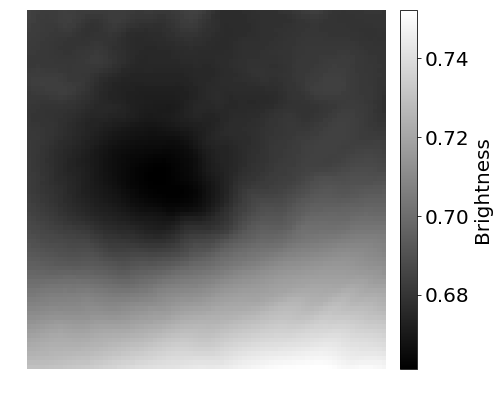

In [46]:
plt.figure(figsize = (7,7))
ax = plt.gca()
ll = plt.imshow(X1[0], cmap='gray')
plt.axis('off')

cb = bm.colorbar(ll, pad='4%', size='5%')
cb.set_label(label='Brightness', size = 20)
cb.ax.tick_params(labelsize=20)

In [48]:
targets = []
for name in tqdm(train_names[:]):
    try:
        X1,X2,y = batch_data_generation(name, train_names[:],df, c_min, c_max)
    
        targets.append(y)
    except:
        pass

100%|██████████| 2203/2203 [11:19<00:00,  3.95it/s]


In [49]:
targets = np.concatenate(targets)

In [50]:
(targets==0).mean()

0.3581793455087321

Training set is nearly balanced so we can use Accuracy as quality metric for NN

### Siamese CNN

In [51]:
def get_siamese_model_2019(input_shape):
 
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    encoder = Sequential()
    encoder.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(32, (3,3), strides=(2,2), activation='relu', input_shape=input_shape, padding='same',
                    kernel_initializer="he_uniform", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(64, (3,3), strides=(2,2), activation='relu',  padding='same',
                      kernel_initializer="he_uniform",
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(128, (3,3), strides=(2,2), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    
    encoder.add(Conv2D(256, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(256, (3,3), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    encoder.add(Conv2D(256, (3,3), strides=(2,2), activation='relu',  kernel_initializer="he_uniform",  padding='same',
                         bias_initializer="Ones", kernel_regularizer=l2(2e-4)))
    
    encoder.add(Flatten())
    encoder.add(Dense(2048, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    encoder.add(Dense(1024, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    encoder.add(Dense(512, activation='relu',
                   kernel_regularizer=l2(1e-3),
                    kernel_initializer="he_uniform",    bias_initializer="Ones"))
    
    encoded_l = encoder(left_input)
    encoded_r = encoder(right_input)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    d1 = Dense(128, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer="he_uniform", bias_initializer="Ones")(L1_distance)
    d2 = Dense(16, activation='relu', kernel_regularizer=l2(1e-3), kernel_initializer="he_uniform", bias_initializer="Ones")(d1)
    
    prediction = Dense(1, activation='sigmoid', bias_initializer="Ones")(d2)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

In [52]:
sim_model = get_siamese_model_2019((80, 80, 1))

Instructions for updating:
Colocations handled automatically by placer.


In [53]:
sim_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          17687744    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential[1][0]                 
          

In [54]:
optimizer = Adam(lr = 0.00001)
sim_model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [55]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.99
 
# Create a session with the above options specified.
tf.keras.backend.set_session(tf.Session(config=config))

In [ ]:
losses_train = []
losses_val = []

for epoch in range(13):
    print('learning %d epoch' % epoch)
    for name in tqdm(train_names[:]):
        try:
            
            X_1, X_2, y = batch_data_generation(name, train_names[:],df, c_min, c_max)
            X_1 = np.asarray([np.expand_dims(x,-1) for x in X_1])
            X_2 = np.asarray([np.expand_dims(x,-1) for x in X_2])
            loss = sim_model.train_on_batch([X_1, X_2], y)
            losses_train.append(loss)
            
        except:
            pass
        
    for name in tqdm(test_names[:]):
        try:

            X_1_pred, X_2_pred, y = batch_data_generation(name, test_names[:],df, c_min, c_max)
            X_1_pred = np.asarray([np.expand_dims(x,-1) for x in X_1_pred])
            X_2_pred = np.asarray([np.expand_dims(x,-1) for x in X_2_pred])
            loss = sim_model.test_on_batch([X_1_pred, X_2_pred],y)
            
            losses_val.append(loss)
        except:
            pass
       

  0%|          | 0/2203 [00:00<?, ?it/s]

learning 0 epoch
Instructions for updating:
Use tf.cast instead.


  0%|          | 1/2203 [00:00<05:22,  6.83it/s]

learning 1 epoch


  0%|          | 1/2203 [00:00<05:27,  6.72it/s]

learning 2 epoch


  0%|          | 1/2203 [00:00<05:18,  6.91it/s]

learning 3 epoch


 39%|███▉      | 855/2203 [06:03<11:44,  1.91it/s]

In [57]:
epochs_loss_train = []
epochs_loss_val = []

indexes_train = range(0,len(losses_train), 2193)
indexes_val = range(0,len(losses_val), 390)

for i in indexes_train:
    epochs_loss_train.append(np.mean(losses_train[i:i+1]))
    
for i in indexes_val:
    epochs_loss_val.append(np.mean(losses_val[i:i+1]))

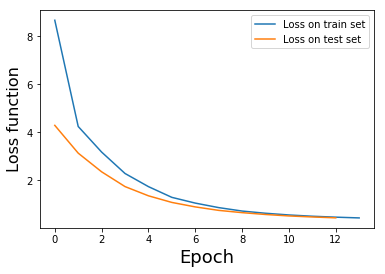

In [58]:
plt.plot(epochs_loss_train, label = 'Loss on train set')
plt.plot(epochs_loss_val, label = 'Loss on test set')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss function', fontsize=16)
plt.legend()


In [59]:
preds = []
y_trues = []
for name in tqdm(test_names[:]):
    try:
        
        X_1_pred, X_2_pred, y = batch_data_generation(name, test_names[:],df, c_min, c_max)
        X_1_pred = np.asarray([np.expand_dims(x,-1) for x in X_1_pred])
        X_2_pred = np.asarray([np.expand_dims(x,-1) for x in X_2_pred])
        probas = sim_model.predict_on_batch([X_1_pred, X_2_pred])
        preds.append(probas)
        y_trues.append(y)
    except:
        pass

100%|██████████| 421/421 [01:53<00:00,  7.06it/s]


In [60]:
preds_bin = (np.concatenate(preds) >= 0.5).astype(np.int)

In [61]:
accuracy_score(preds_bin,np.concatenate(y_trues))

0.9958008398320336

In [62]:
sim_model.save('./siamese_model_0.9958.h5')

## Load weights


In [63]:
sim_model = load_model('./siamese_model_0.9958.h5')

## MOTA and Tracking

In [64]:
def MOTA(predicted_tracks, ground_truth_tracks, df, datetimes):
    global_mota = []
    
    for key in tqdm(predicted_tracks.keys()):

        motas_for_given_track = []
        
        track = predicted_tracks[key]
        
        start_time = str(df[(df['name'] == track[0][0]) & (df['index'] == track[0][1])]['datetime'].tolist()[0])
        end_time = str(df[(df['name'] == track[-1][0]) & (df['index'] == track[-1][1])]['datetime'].tolist()[0])
        
        for start_index,j in enumerate(datetimes):
            if j == np.datetime64(start_time):
                break

        for end_index,j in enumerate(datetimes):
            if j == np.datetime64(end_time): 
                break
                
        indexes = [i for i in range(start_index, end_index + 1)]
                
        alls = []
        for i in range(len(datetimes)):
            if ((datetimes[i] >= np.datetime64(start_time)) &  (datetimes[i] <= np.datetime64(end_time))):
                sr = df[df['datetime'] == datetimes[i]]['name'].tolist()
                for j in sr:
                    if j not in alls:
                        alls.append(j)
                    
        for true_name in alls:
            start_true = str(df[(df['name'] == ground_truth_tracks[true_name][0][0]) & (df['index'] == ground_truth_tracks[true_name][0][1])]['datetime'].tolist()[0])
            if np.datetime64(start_true) not in datetimes:
                start_true = "2004-09-07 03:00:00"
                for i in range(len(ground_truth_tracks[true_name])):
                    shift = str(df[(df['name'] == ground_truth_tracks[true_name][i][0]) & (df['index'] == ground_truth_tracks[true_name][i][1])]['datetime'].tolist()[0])
                    if shift == start_true:
                        ground_truth_tracks[true_name] = ground_truth_tracks[true_name][i:]
                        break
                
                
                
            end_true = str(df[(df['name'] == ground_truth_tracks[true_name][-1][0]) & (df['index'] == ground_truth_tracks[true_name][-1][1])]['datetime'].tolist()[0])
            
            try:
                
                for start_index_true,j in enumerate(datetimes):
                    if j == np.datetime64(start_true):
                        break

                for end_index_true,j in enumerate(datetimes):
                    if j == np.datetime64(end_true):
                        break
                
    
                indexes_true = [i for i in range(start_index_true, end_index_true + 1)]
                if len(indexes_true) == 0:
                    continue
                commons, pred_inds, tr_inds = np.intersect1d(indexes,indexes_true, return_indices=True)
                pred_ind = pred_inds[0]
                tr_ind = tr_inds[0]

            except:
                continue
            
            # False Positives computing
            try:
                FP = 0
                for _ in range(len(commons)):
                    if track[pred_inds[pred_ind]][2:] != ground_truth_tracks[true_name][tr_inds[tr_ind]][2:]:      
                        FP += 1
                    pred_ind += 1 
                    tr_ind += 1
                    
            except:
                
                FP = 0
                        
            
            # Misses computing       
            if np.datetime64(end_time) > np.datetime64(end_true):
                Miss = pred_inds[0]
            else:
                Miss = pred_inds[0] + len(indexes_true) - len(indexes)
    
            mota = 1 - (FP + Miss)/len(ground_truth_tracks[true_name])
            
            motas_for_given_track.append(mota)
        
        mean_mota = np.mean(motas_for_given_track)
        global_mota.append(mean_mota)
    
    return global_mota
    

In [65]:
def open_image_and_filtering_prerocess_for_NN(name, index):
    
    pi_name = "./Cuts/" + str(name)
    
    with open(pi_name, 'rb') as fp:
        cyclone_track = pickle.load(fp)
        cyclone_track = cyclone_track[index][0]
        cyclone_track  = [cyclone_track [np.newaxis,:,:]]
        #cyclone_track = np.concatenate(cyclone_track_data, axis=0)
        cyclone_track = (cyclone_track[0]-c_min)/(c_max-c_min)
        
        expanded = np.asarray([np.expand_dims(x,-1) for x in cyclone_track])
        
        
    return expanded

In [66]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2010-01-01 15:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:] 
        
global_dict = {}

#initial dict
initial_srez = df[df['datetime'] == datetimes[0]]
for i in range(len(initial_srez)):
    global_dict[i] = []
    global_dict[i].append(list(initial_srez.values[i][1:]))
    

for key in tqdm(global_dict.keys()):

    
    for timestamp in range(0,300):

        #open what we want to compare
        name,index,lat,long = global_dict[key][-1]

        first_input = open_image_and_filtering_prerocess_for_NN(name,index)
        
        next_index = timestamp + 1

        probs = {}

        for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 
            second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
            
            proba = sim_model.predict_on_batch([first_input, second_input])
            
            probs[new_name] = [proba, new_index,  new_lat, new_long]

        target_name = max(probs.items(), key=lambda x: x[1][0])[0]
        target_index, target_lat, target_long = probs[target_name][1:]
    
        if probs[target_name][0] < 0.15 :
            break
            
        global_dict[key].append([target_name, target_index, target_lat, target_long])


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [67]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2010-01-01 15:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:]

for global_timestamp in tqdm(range(1, len(datetimes)-1)):
    current_srez = df[df['datetime'] == datetimes[global_timestamp]]
    
    new_keys = []

    for find_new in current_srez.values:
        isNew = True
        for key in global_dict.keys():
            for item in global_dict[key]:
                if (item[2] == find_new[3]) & (item[3] == find_new[4]):
                    isNew = False
                    break
        if isNew:
            key_to_add = len(global_dict)
            new_keys.append(key_to_add)
            global_dict[key_to_add] = []
            global_dict[key_to_add].append(list(find_new[1:]))

    for new_key in new_keys:
        
        max_time_stamp = global_timestamp + 300
        if max_time_stamp >= len(datetimes)-1:
            max_time_stamp = len(datetimes)-2
        
        for timestamp in range(global_timestamp, max_time_stamp):
        



            #open what we want to compare
            name,index,lat,long = global_dict[new_key][-1]
            
            try:
                first_input = open_image_and_filtering_prerocess_for_NN(name,index)
            except:
                break


            next_index = timestamp + 1

            probs = {}


            for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 

                try:
                    second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
                except:
                    continue


                proba = sim_model.predict_on_batch([first_input, second_input])

                probs[new_name] = [proba, new_index,  new_lat, new_long]

            try:

                target_name = max(probs.items(), key=lambda x: x[1][0])[0]
                target_index, target_lat, target_long = probs[target_name][1:]


                if probs[target_name][0] < 0.15:
                    break
                    
                global_dict[new_key].append([target_name, target_index, target_lat, target_long])

            except:
                break    

100%|██████████| 15628/15628 [13:13<00:00, 63.04it/s] 


In [68]:
names_true_tracks = np.unique([track[i][0] for track in list(global_dict.values()) for i in range(len(track))])

In [69]:
true_tracks_dict = {}
for name in tqdm(names_true_tracks):
    true_tracks_dict[name] = df[df['name'] == name].values[:,1:].tolist()

100%|██████████| 421/421 [00:13<00:00, 31.91it/s]


## Saving

In [70]:
with open('TCNN_tracks.p', 'wb') as fp:
    pickle.dump(global_dict , fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('TC_true_tracks.p', 'wb') as fp:
    pickle.dump(true_tracks_dict , fp, protocol=pickle.HIGHEST_PROTOCOL)   

## Loading

In [71]:
with open('TCNN_tracks.p', 'rb') as fp:
    global_dict = pickle.load(fp)
    
with open('TC_true_tracks.p', 'rb') as fp:
    true_tracks_dict = pickle.load(fp)

In [72]:
c = MOTA(global_dict, true_tracks_dict, df, datetimes)

100%|██████████| 1356/1356 [19:54<00:00,  1.21s/it]


In [73]:
np.mean(c)

0.14327005253614278

In [74]:
lengths_true = []
lengths_pred = []
for key in true_tracks_dict.keys():
    lengths_true.append(len(true_tracks_dict[key]))
    
for key in global_dict.keys():
    lengths_pred.append(len(global_dict[key]))

Text(0, 0.5, 'Quantity')

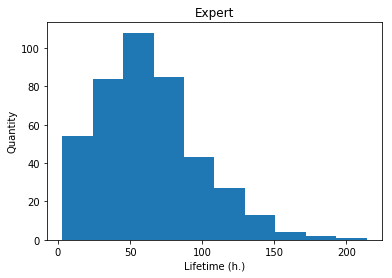

In [75]:
plt.hist(lengths_true, bins = 10)
plt.title("Expert")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

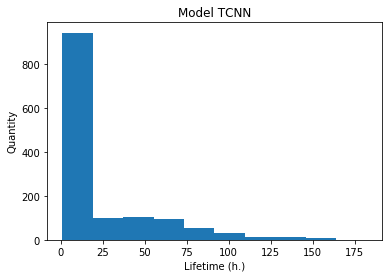

In [76]:
plt.hist(lengths_pred, bins = 10)
plt.title("Model TCNN")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('TCNN_distr.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

## Confident intervals

In [77]:
#returns confidence interval of mean
def confIntMean(a, conf=0.99):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    
    return mean - m*sem, mean + m*sem

motas = np.array([0.1573, 0.1454, 0.1454, 0.1465, 0.1464, 0.1437])
nn_accuracy = np.array([0.9841, 0.9955, 0.9955, 0.9954, 0.9951, 0.9958])
print(confIntMean(motas, conf=0.95))
print(confIntMean(nn_accuracy, conf=0.95))


(0.1422769102899033, 0.15262308971009664)
(0.9886939993789587, 0.9984393339543747)


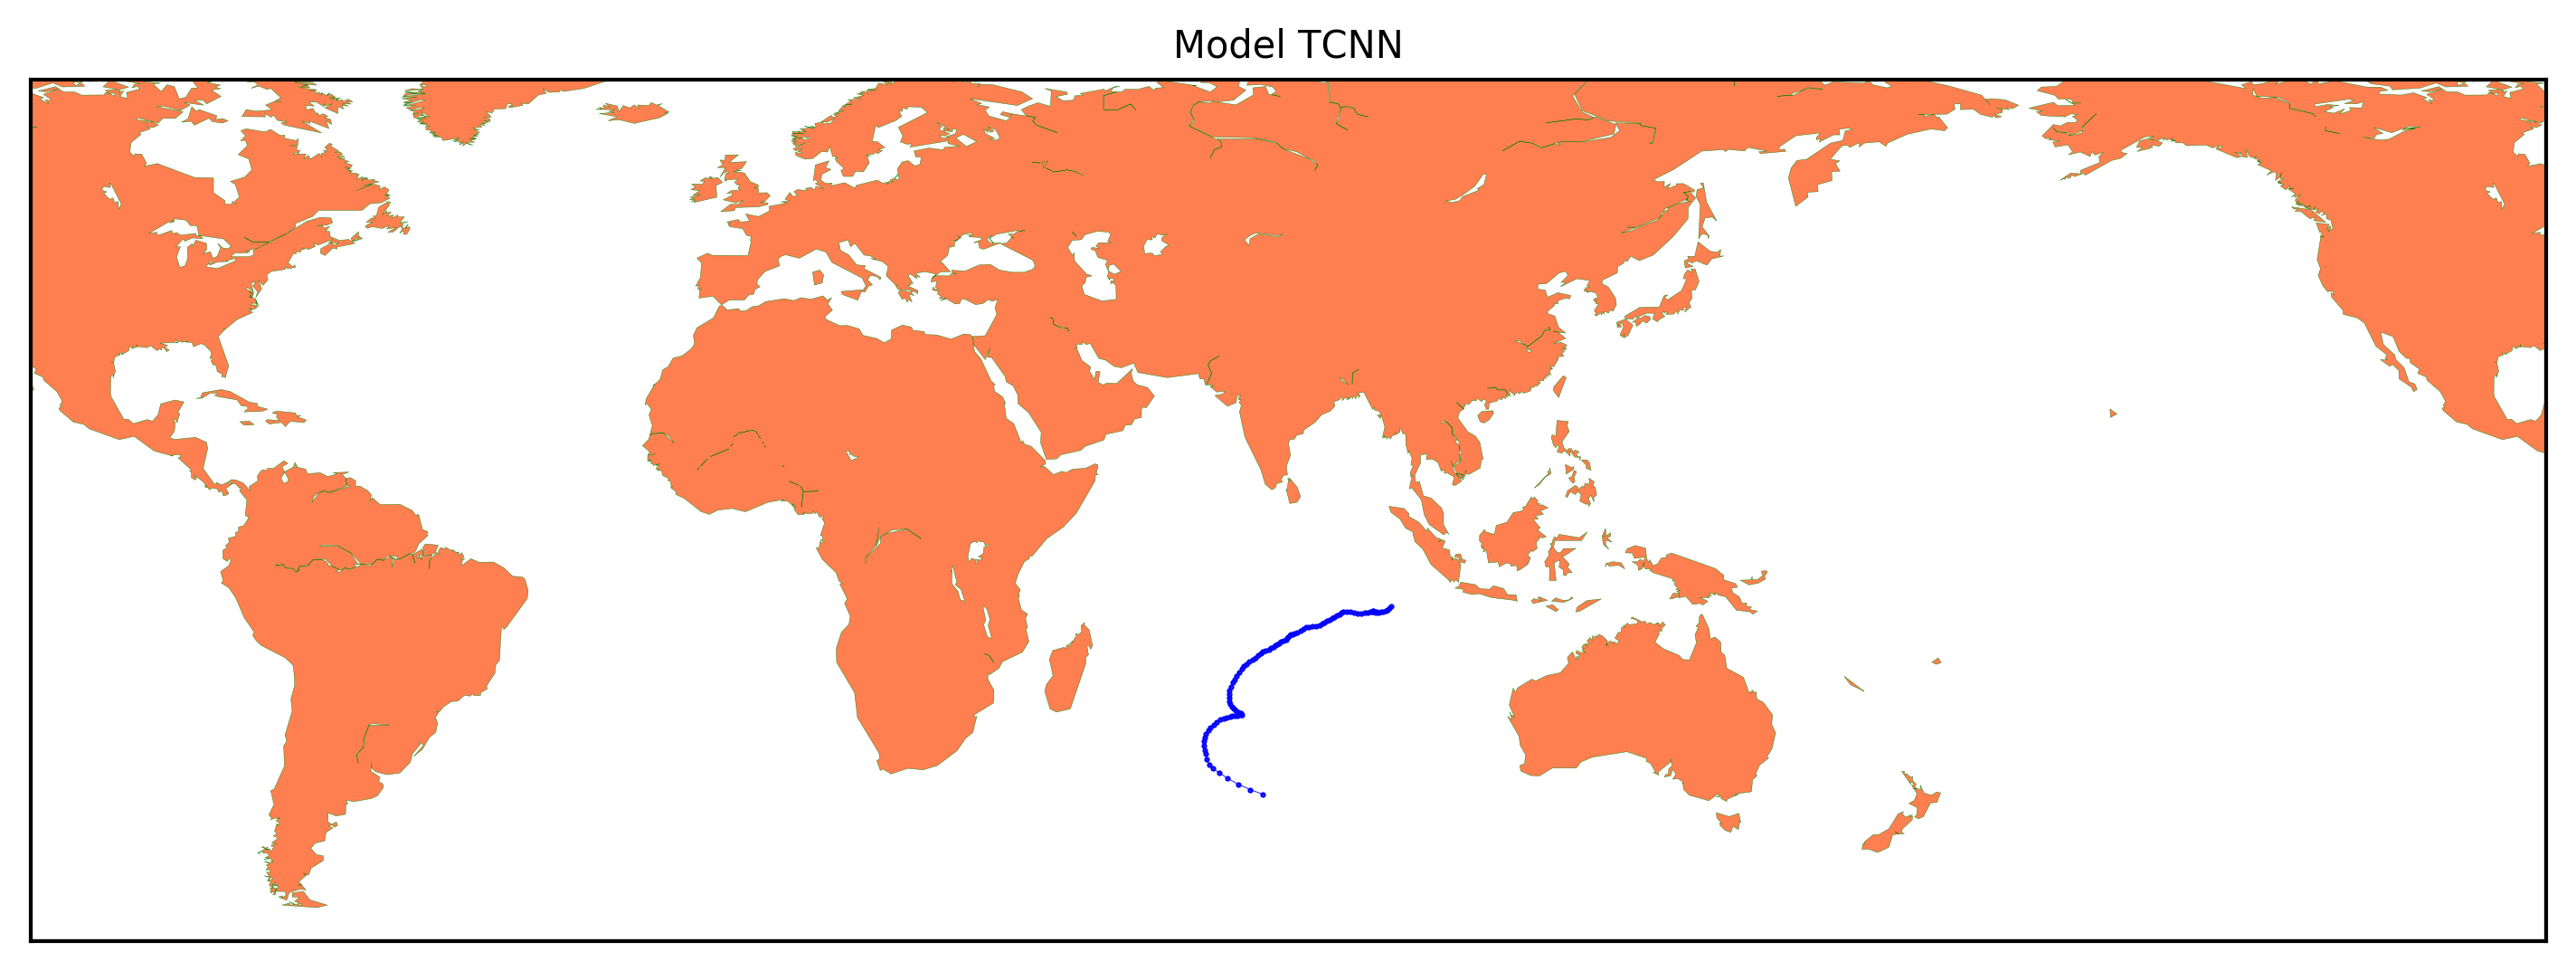

In [78]:
x_pred = []
y_pred = []
for i in global_dict[0]:
    x_pred.append(i[2])
    y_pred.append(i[3])
    

names = []
for i in range(len(global_dict[0])):
    names.append(global_dict[0][i][0])

from mpl_toolkits.basemap import Basemap 
fig, (ax1) = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.tight_layout()

ax1.set_title("Model TCNN", fontsize=10)
bm = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-110, urcrnrlon=270, resolution='c', ax = ax1)

x_,y_ = bm(y_pred, x_pred)
bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)

bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)

#plt.savefig('draw_TCNN_good.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

100%|██████████| 108/108 [00:44<00:00,  1.36it/s]


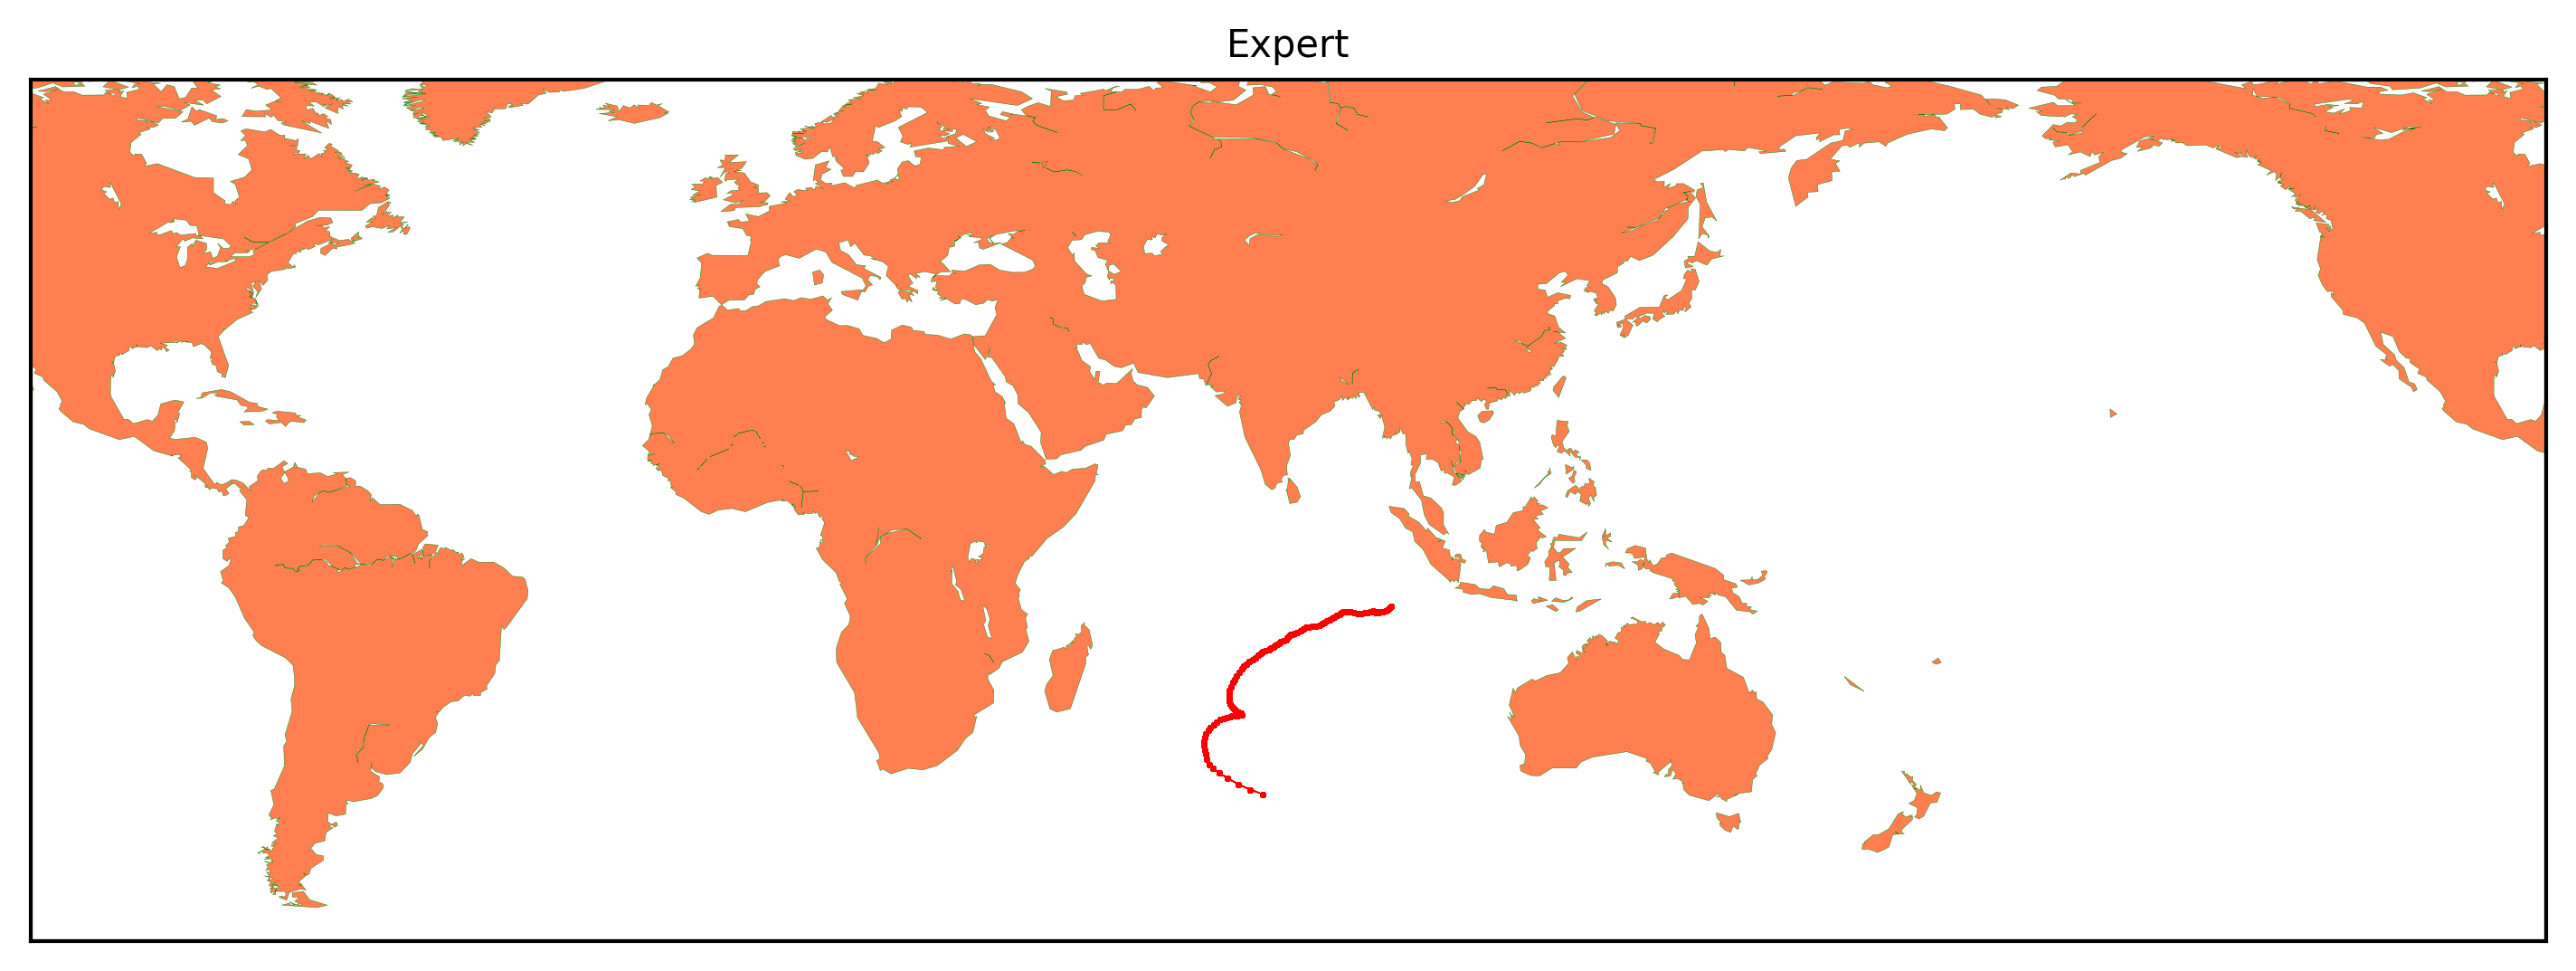

In [79]:
fig, (ax2) = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.tight_layout()
ax2.set_title("Expert", fontsize=10)
bm = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-110, urcrnrlon=270, resolution='c', ax = ax2)

for name in tqdm(names):
    x_t = []
    y_t = []
    for k in true_tracks_dict[name]:
        x_t.append(k[2])
        y_t.append(k[3])
        
        x_t_,y_t_ = bm(y_t, x_t)
        bm.plot(x_t_, y_t_,  marker = 'o', color='r', markersize=0.5, linewidth=0.2)


bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('draw_expert_good_TC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()   

# Random tracker

In [80]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2010-01-01 15:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:] 
        
global_dict = {}

#initial dict
initial_srez = df[df['datetime'] == datetimes[0]]
for i in range(len(initial_srez)):
    global_dict[i] = []
    global_dict[i].append(list(initial_srez.values[i][1:]))
    

for key in tqdm(global_dict.keys()):
    #print(key)
    
    for timestamp in range(0,620):

        name,index,lat,long = global_dict[key][-1]

        first_input = open_image_and_filtering_prerocess_for_NN(name,index)
        
        next_index = timestamp + 1

        probs = {}

        for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 
            second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
            
            proba = np.random.uniform(0, 1)

            probs[new_name] = [proba, new_index,  new_lat, new_long]

        target_name = max(probs.items(), key=lambda x: x[1][0])[0]
        target_index, target_lat, target_long = probs[target_name][1:]
    
        if probs[target_name][0] < 0.5 :
            break
            
        global_dict[key].append([target_name, target_index, target_lat, target_long])


100%|██████████| 1/1 [00:00<00:00, 29.48it/s]


In [81]:
datetimes = df['datetime'].values
datetimes = np.unique(datetimes)
datetimes.sort()
datetimes = list(datetimes)

date_start = "2010-01-01 15:00:00"
for start_index,j in enumerate(datetimes):
    if j == np.datetime64(date_start):
        break
        
datetimes = datetimes[start_index:]

for global_timestamp in tqdm(range(1, len(datetimes)-1)):
    current_srez = df[df['datetime'] == datetimes[global_timestamp]]
    
    new_keys = []

    for find_new in current_srez.values:
        isNew = True
        for key in global_dict.keys():
            for item in global_dict[key]:
                if (item[2] == find_new[3]) & (item[3] == find_new[4]):
                    isNew = False
                    break
        if isNew:
            key_to_add = len(global_dict)
            new_keys.append(key_to_add)
            global_dict[key_to_add] = []
            global_dict[key_to_add].append(list(find_new[1:]))

    for new_key in new_keys:
        
        max_time_stamp = global_timestamp + 620
        if max_time_stamp >= len(datetimes)-1:
            max_time_stamp = len(datetimes)-2
        
        for timestamp in range(global_timestamp, max_time_stamp):
        
            name,index,lat,long = global_dict[new_key][-1]
            
            try:
                first_input = open_image_and_filtering_prerocess_for_NN(name,index)
            except:
                break


            next_index = timestamp + 1

            probs = {}


            for new_name, new_index, new_lat, new_long in df[df['datetime'] == datetimes[next_index]][['name', 'index', 'lat', 'long']].values: 

                try:
                    second_input = open_image_and_filtering_prerocess_for_NN(new_name, new_index)
                except:
                    continue

                proba = np.random.uniform(0, 1)

                probs[new_name] = [proba, new_index,  new_lat, new_long]

            try:

                target_name = max(probs.items(), key=lambda x: x[1][0])[0]
                target_index, target_lat, target_long = probs[target_name][1:]


                if probs[target_name][0] < 0.5:
                    break
                    
                global_dict[new_key].append([target_name, target_index, target_lat, target_long])

            except:
                break    

100%|██████████| 15628/15628 [07:56<00:00, 32.79it/s]


In [82]:
names_true_tracks = np.unique([track[i][0] for track in list(global_dict.values()) for i in range(len(track))])

In [83]:
true_tracks_dict = {}
for name in tqdm(names_true_tracks):
    true_tracks_dict[name] = df[df['name'] == name].values[:,1:].tolist()

100%|██████████| 421/421 [00:13<00:00, 31.74it/s]


## SAVING

In [84]:
with open('random_TC_tracks.p', 'wb') as fp:
    pickle.dump(global_dict , fp, protocol=pickle.HIGHEST_PROTOCOL)

## LOADING

In [85]:
import pickle
with open('random_TC_tracks.p', 'rb') as fp:
    global_dict = pickle.load(fp)
    
with open('TC_true_tracks.p', 'rb') as fp:
    true_tracks_dict = pickle.load(fp)

In [86]:
c = MOTA(global_dict, true_tracks_dict, df, datetimes)

100%|██████████| 9434/9434 [1:52:24<00:00,  1.48it/s]  


In [87]:
np.mean(c)

0.04929474376590934

In [88]:
lengths_true = []
lengths_pred = []
for key in true_tracks_dict.keys():
    lengths_true.append(len(true_tracks_dict[key]))
    
for key in global_dict.keys():
    lengths_pred.append(len(global_dict[key]))

Text(0, 0.5, 'Quantity')

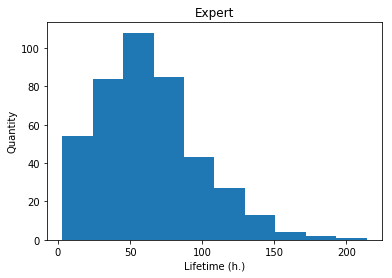

In [89]:
#pidpis = range(0,250,50)
#labels = ['0', '50', '100', '150', '200',  '250']
plt.hist(lengths_true, bins = 10)
plt.title("Expert")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

#plt.savefig('expert_distr_TC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

(0, 200)

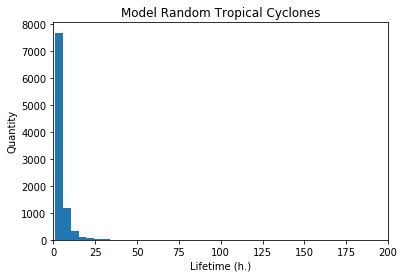

In [90]:
#pidpis = range(0,50,10)
#labels = ['0', '50', '100', '150', '200',  '250']
plt.hist(lengths_pred, bins = 10)
#plt.xticks(pidpis, labels)
plt.title("Model Random Tropical Cyclones")
plt.xlabel("Lifetime (h.)")
plt.ylabel("Quantity")

axes = plt.gca()
axes.set_xlim([0,200])
#plt.savefig('random_TC_distr.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

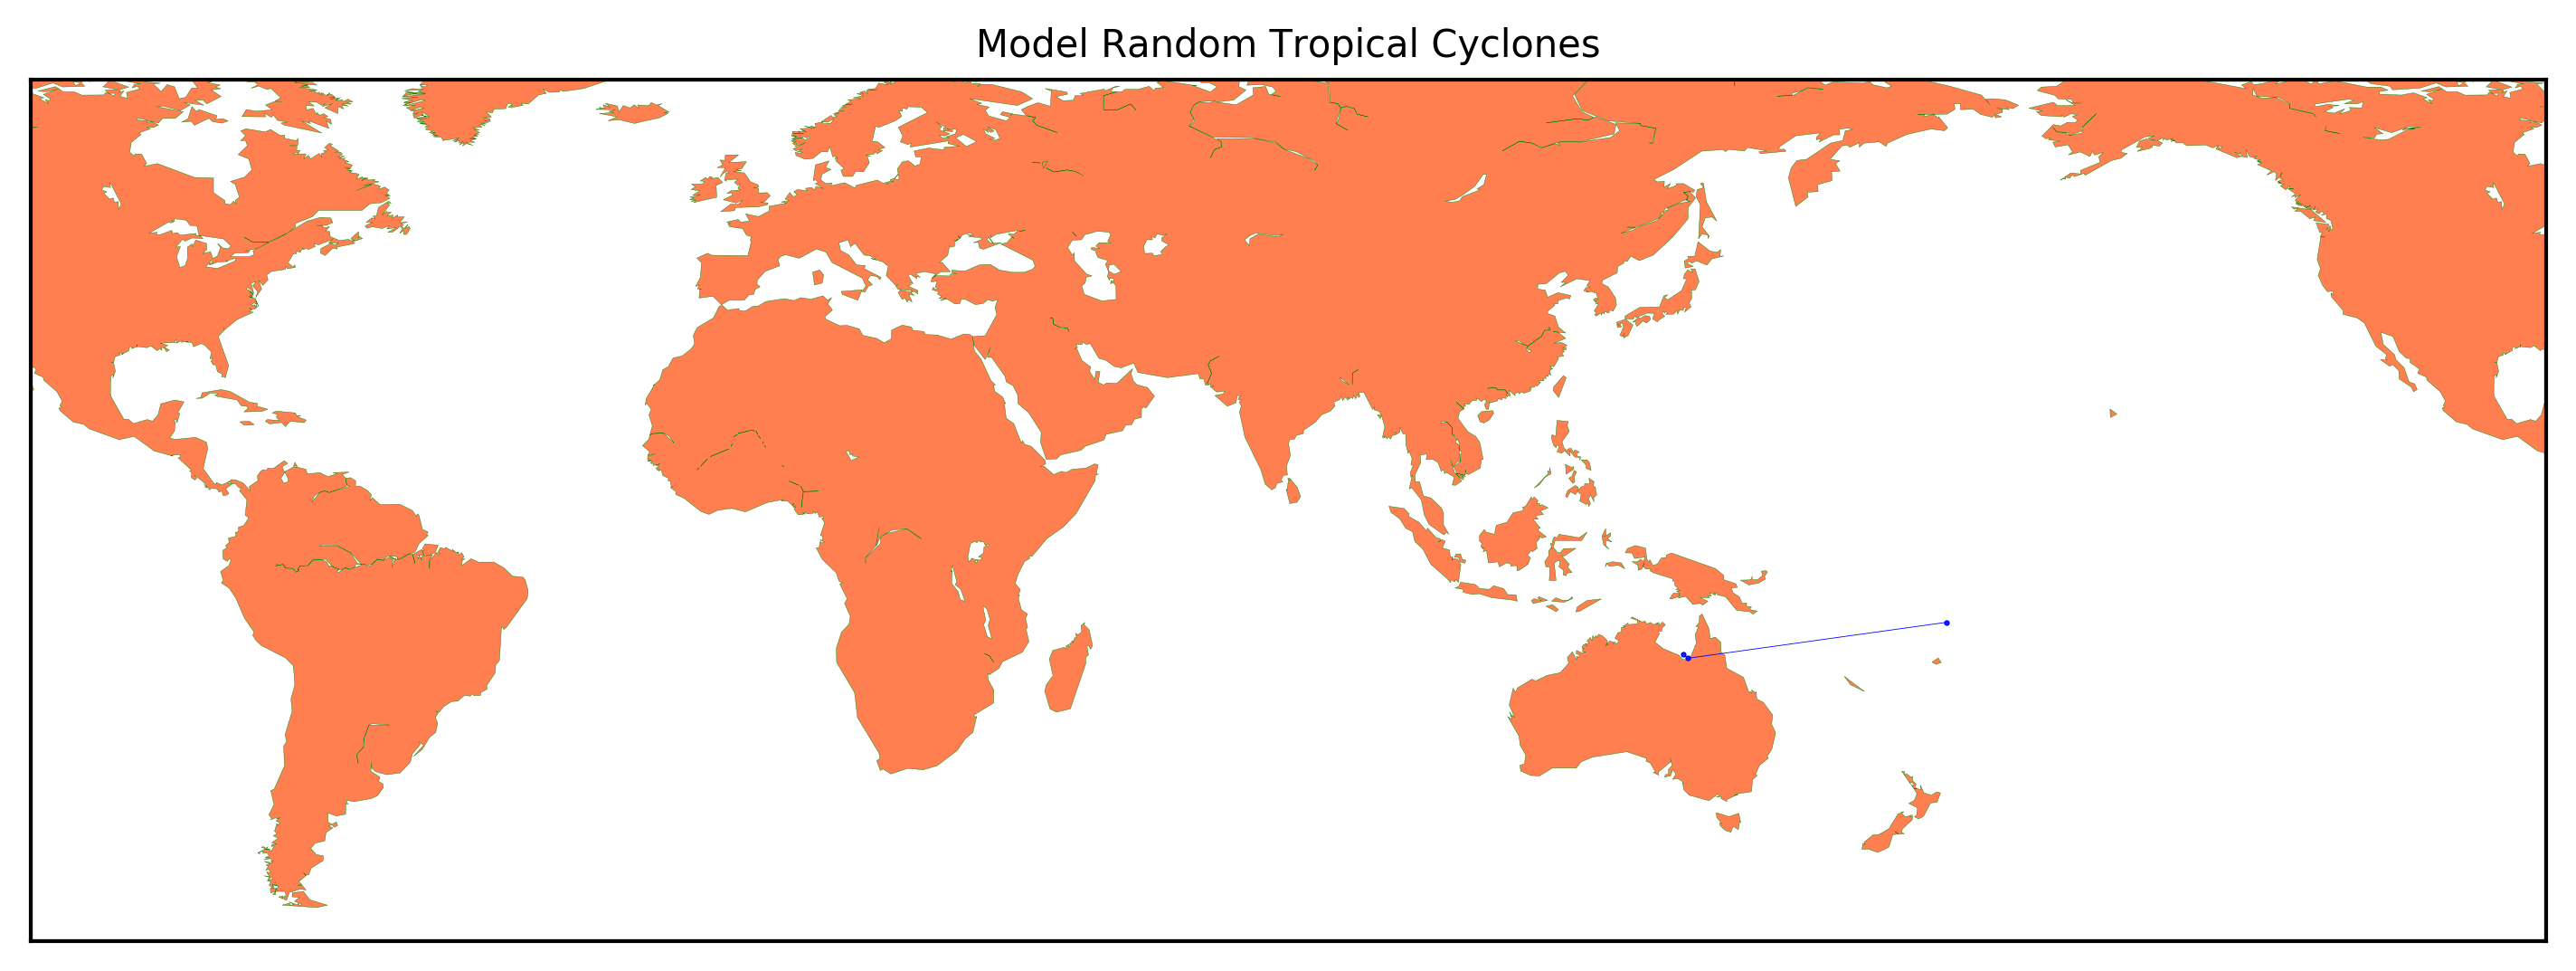

In [93]:
x_pred = []
y_pred = []
for i in global_dict[100]:
    x_pred.append(i[2])
    y_pred.append(i[3])
    

names = []
for i in range(len(global_dict[100])):
    names.append(global_dict[100][i][0])

from mpl_toolkits.basemap import Basemap 
fig, (ax1) = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.tight_layout()

ax1.set_title("Model Random Tropical Cyclones", fontsize=10)
bm = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-110, urcrnrlon=270, resolution='c', ax = ax1)

x_,y_ = bm(y_pred, x_pred)
bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)

bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)

#plt.savefig('draw_random_TC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')
plt.show()

100%|██████████| 3/3 [00:00<00:00, 19.21it/s]


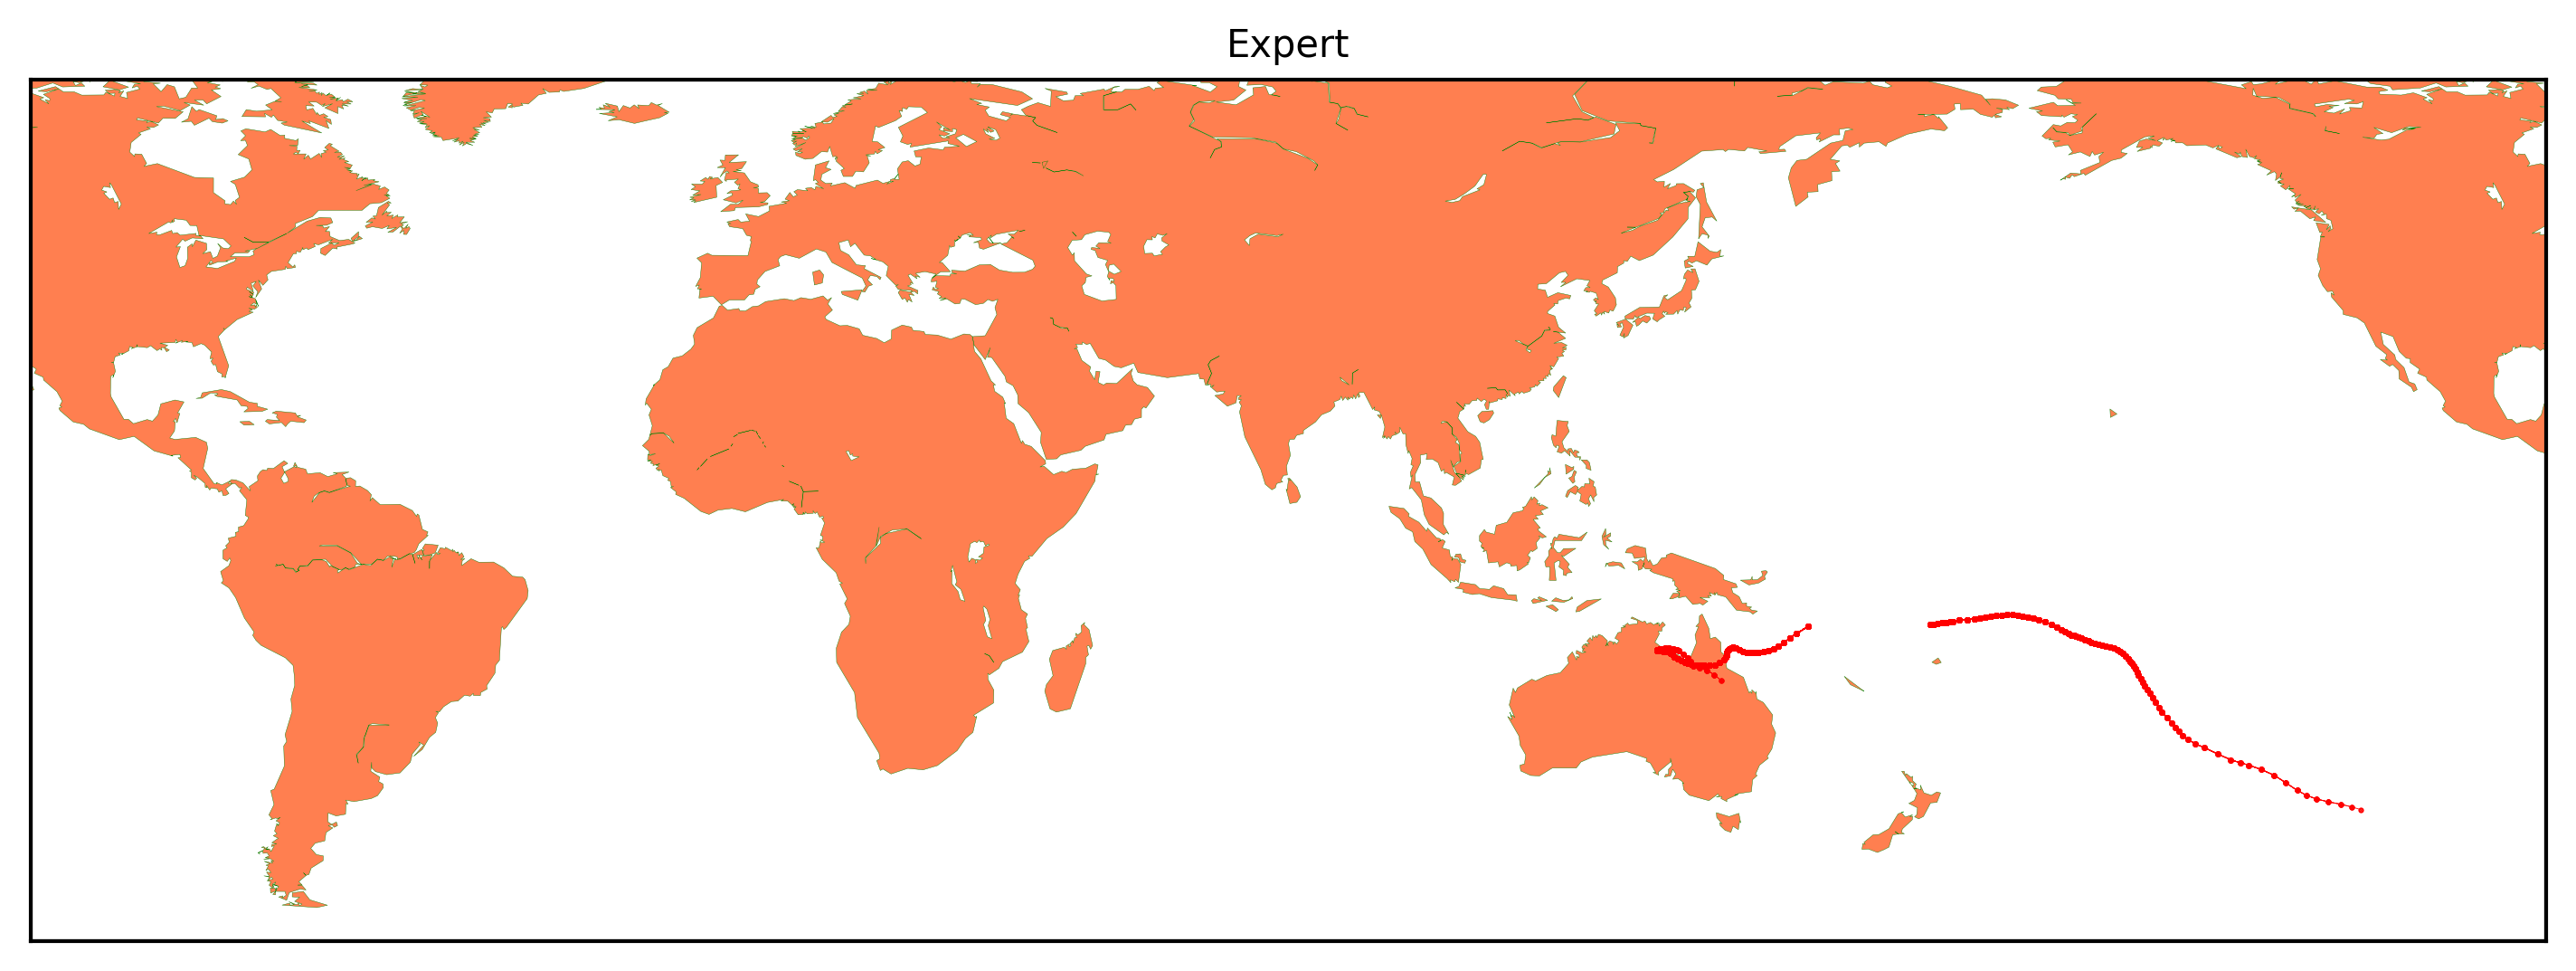

In [92]:
from matplotlib.backends.backend_pdf import PdfPages
fig, (ax2) = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.tight_layout()
ax2.set_title("Expert", fontsize=10)
bm = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-110, urcrnrlon=270, resolution='c', ax = ax2)

for name in tqdm(names):
    x_t = []
    y_t = []
    for k in true_tracks_dict[name]:
        x_t.append(k[2])
        y_t.append(k[3])
        
        x_t_,y_t_ = bm(y_t, x_t)
        bm.plot(x_t_, y_t_,  marker = 'o', color='r', markersize=0.5, linewidth=0.2)


bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('draw_expert_random_TC.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')

### All tracks for 20 years

In [94]:
df_all = pd.DataFrame(columns=['datetime', 'name', 'index'])
for name in tqdm(cyclones_20_years[:]):
    for i in range(len(cyclones[name])):
        lat = cyclones[name][i][1]
        long = cyclones[name][i][2]
        df_all = df_all.append({'datetime' : datetime.strptime(cyclones[name][i][0].strftime('%Y-%m-%d %H:%M:%S'), '%Y-%m-%d %H:%M:%S'),
               'name':name ,'index' : i, 'long' : long, 'lat' : lat } , ignore_index=True)

100%|██████████| 3997/3997 [29:45<00:00,  1.18it/s]


In [95]:
df_all = df_all.sort_values(by='datetime')

In [96]:
all_tracks_dict = {}
for name in tqdm(cyclones_20_years):
    all_tracks_dict[name] = df_all[df_all['name'] == name].values[:,1:].tolist()

100%|██████████| 3997/3997 [02:51<00:00, 23.31it/s]


100%|██████████| 3997/3997 [00:07<00:00, 511.67it/s]


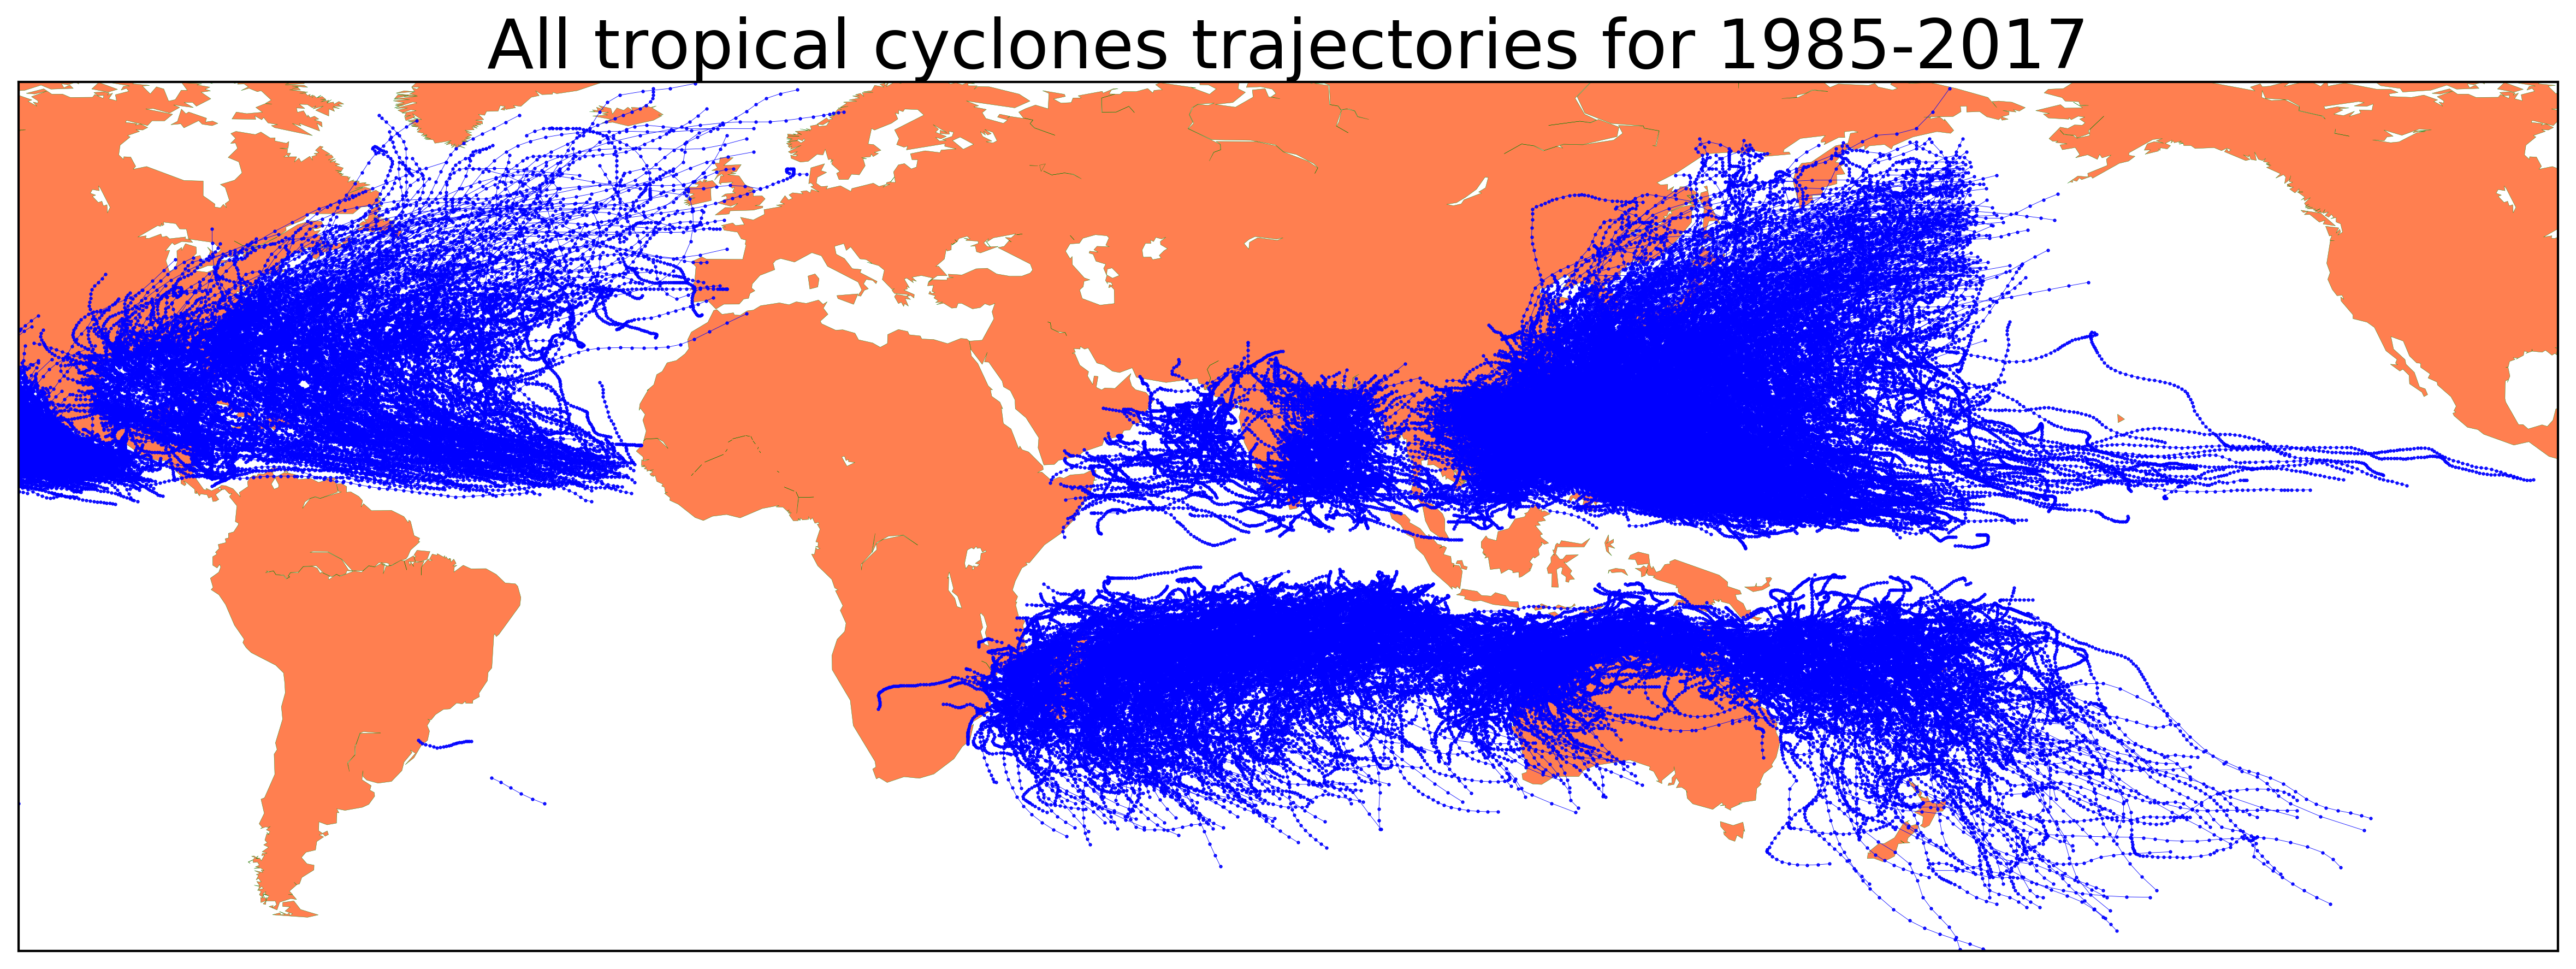

In [97]:
plt.figure(figsize=(20,10), dpi = 300)
plt.title("All tropical cyclones trajectories for 1985-2017", fontsize=30)

bm = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-110, urcrnrlon=270, resolution='c')
for key in tqdm(all_tracks_dict.keys()):
    x_loc = []
    y_loc = []
    for i in all_tracks_dict[key]:
        x_loc.append(i[2])
        y_loc.append(i[3])
        
    x_,y_ = bm(y_loc, x_loc)
    bm.plot(x_[:], y_[:], marker = 'o', color='b', markersize=0.5, linewidth=0.2)
    


bm.fillcontinents(color = 'coral')
bm.drawmapboundary()
bm.drawcoastlines(color='green', linewidth=0.1)


#plt.savefig('all_TC_tracks.pdf', dpi = 200, bbox_inches = 0.0, pad_inches = 0.0, format = 'pdf')